# Data integration

In [1]:
# Python packages
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import anndata as ad

os.chdir("/data/home/wx/islets") 

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

2024-03-25 20:11:16.599739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_2830732/2669650136.py:22: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:

adata = sc.read(
    filename="data/pancdb/T1D_T2D_public.h5ad",
)

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/donor_id' was written without encoding metadata.
  return func(*args, **kwargs)
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/donor_id' was written without encoding metadata.
  return func(*args, **kwargs)
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/cell_type' was written without encoding metadata.
  return func(*args, **kwargs)
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/cell_typ

In [3]:
adata.obs['donor_id'].to_csv('donorid.csv')

### scislets cell colors
adata.obs['manual_celltype_annotation'] = adata.obs.manual_celltype_annotation.cat.set_categories([
    'Beta', 'Immature Beta','Stressed Beta','Alpha','Delta', 'Pancreatic Progenitor', "Epsilon", 'EC'])
array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b','#e377c2', '#b5bd61', '#17becf'], dtype=object)

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/pl

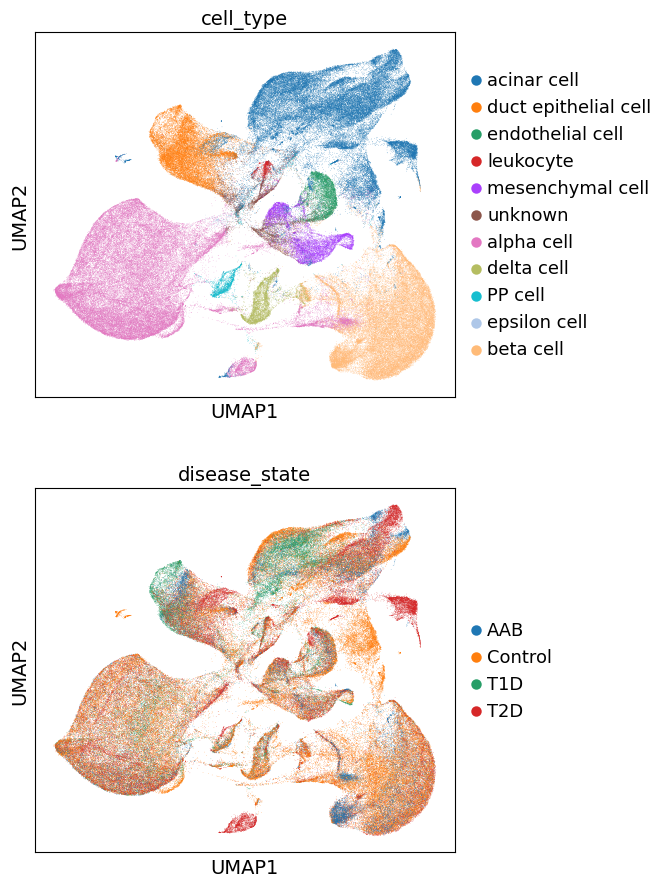

In [4]:
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(5, 5))
sc.pl.umap(adata, color=['cell_type', 'disease_state'], ncols=1)

In [5]:
adata.layers['counts'] = adata.X.astype(int).copy()
adata.raw = adata
adata = adata[adata.obs['disease_state'].isin (['Control','T2D'])].copy()
adata = adata[adata.obs['cell_type'].isin (['beta cell','alpha cell','delta cell','epsilon cell'])].copy()

In [6]:
adata.obs['donor_id'].cat.categories

Index(['HPAP022', 'HPAP026', 'HPAP027', 'HPAP034', 'HPAP035', 'HPAP036',
       'HPAP037', 'HPAP039', 'HPAP040', 'HPAP042', 'HPAP044', 'HPAP047',
       'HPAP051', 'HPAP052', 'HPAP053', 'HPAP054', 'HPAP056', 'HPAP057',
       'HPAP058', 'HPAP059', 'HPAP061', 'HPAP062', 'HPAP063', 'HPAP065',
       'HPAP067', 'HPAP069', 'HPAP070', 'HPAP074', 'HPAP075', 'HPAP077',
       'HPAP079', 'HPAP080', 'HPAP081', 'HPAP082', 'HPAP083', 'HPAP085',
       'HPAP088', 'HPAP090', 'HPAP091', 'HPAP093', 'HPAP099', 'HPAP100',
       'HPAP101', 'HPAP103', 'HPAP104', 'HPAP105', 'HPAP106', 'HPAP109'],
      dtype='object')

005,006,011,017,018,024,026,034,038,042,044,072,082,104,107,129,131,148,
065,076,079,058,081,088,090,091,096,100,108,109,115,120,134,145,147,150,152,162,163,165

In [7]:
###T2D: HBA1C >=6.5; NORMAL HBA1C <5.7
adata = adata[adata.obs['donor_id'].isin (['HPAP022','HPAP024','HPAP026','HPAP027','HPAP029','HPAP034',
                                           'HPAP035','HPAP036','HPAP037','HPAP038','HPAP040','HPAP042',
                                           'HPAP044','HPAP045','HPAP049','HPAP050','HPAP052','HPAP053',
                                           'HPAP054','HPAP056','HPAP059','HPAP072','HPAP077','HPAP080',
                                           'HPAP082','HPAP092','HPAP099','HPAP101','HPAP104','HPAP105',
                                           'HPAP107', ### ND
                                           'HPAP051','HPAP058','HPAP065','HPAP070','HPAP079','HPAP081',
                                           'HPAP085','HPAP088','HPAP090','HPAP091','HPAP100','HPAP109'])].copy()### T2D

In [8]:
adata.write("processed/adata_subset.h5ad")

In [9]:
#label_key = "manual_celltype_annotation"
batch_key = "donor_id"
label_key = "cell_type"

In [10]:
adata.obs.donor_id

AAACCTGAGGTGTGGT-2     HPAP022
AAACCTGCACGCCAGT-2     HPAP022
AAACCTGCAGTCGATT-2     HPAP022
AAACCTGTCACCCTCA-2     HPAP022
AAACCTGTCCCGACTT-2     HPAP022
                        ...   
TTTGACTCAACGATTC-67    HPAP109
TTTGATCTCCTCAGGG-67    HPAP109
TTTGATCTCCTCGCAT-67    HPAP109
TTTGGTTCATGGTACT-67    HPAP109
TTTGGTTGTATCGAGG-67    HPAP109
Name: donor_id, Length: 55866, dtype: category
Categories (34, object): ['HPAP022', 'HPAP026', 'HPAP027', 'HPAP034', ..., 'HPAP101', 'HPAP104', 'HPAP105', 'HPAP109']

In [11]:
adata.X = adata.layers["counts"].copy()
adata.raw = adata#保存原始矩阵

In [12]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

In [14]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

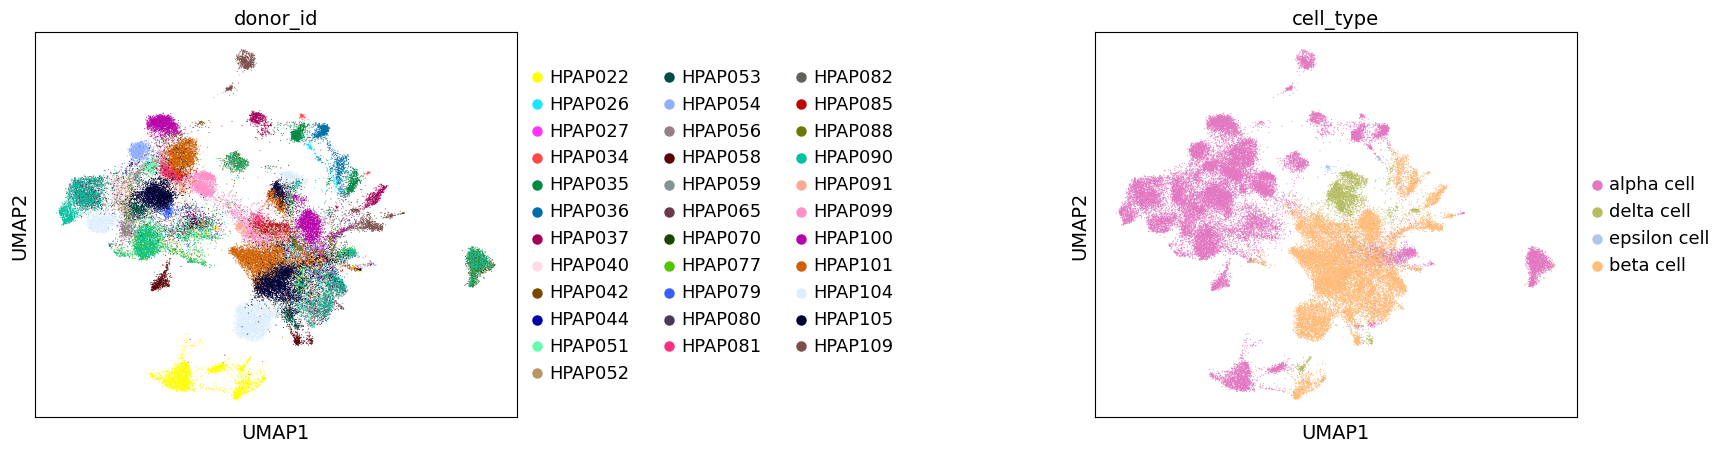

In [15]:
sc.pl.umap(adata, color=[batch_key, label_key], wspace=1)

## Batch-aware feature selection

In [16]:
adata.X = adata.layers ['counts'].copy()
adata.raw = adata  # keep full dimension safe
adata.X = adata.layers ['logcounts'].copy()

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5, 
                            subset= True)

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [18]:
adata

AnnData object with n_obs × n_vars = 55776 × 1015
    obs: 'donor_id', 'cell_type', 'assay', 'sex', 'age', 'race', 'disease_state', 'n_genes'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_normalization', 'cell_type_ontology_term_id_colors', 'schema_version', 'title', 'cell_type_colors', 'disease_state_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'donor_id_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

## Variational autoencoder (VAE) based integration

### Data preparation

In [19]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=batch_key)

### Building the model

In [20]:
model_scvi = scvi.model.SCVI(adata,n_layers=2, n_latent=30, gene_likelihood="nb")
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [21]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'donor_id',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  34   │
│         n_cells          │ 55776 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 1015  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │  HPAP022   │          0          │
│                       │  HPAP026   │          1          │
│                       │  HPAP027   │          2          │
│                       │  HPAP034   │          3          │
│                       │  HPAP035   │          4          │
│                       │  HPAP036   │          5          │
│                       │  HPAP037   │          6          │
│                       │  HPAP040   │          7          │
│                       │  HPAP042   │          8          │
│                       │  HPAP044   │          9          │
│                       │  HPAP051   │         10          │
│                       │  HPAP052   │         11          │
│                       │  HPAP053   │         12          │
│                       │  HPAP054   │         13          │
│                       │  HPAP056   │         14          │
│                       │  HPAP058   │         15          │
│                       │  HPAP059   │         16          │
│                       │  HPAP065   │         17          │
│                       │  HPAP070   │         18          │
│                       │  HPAP077   │         19          │
│                       │  HPAP079   │         20          │
│                       │  HPAP080   │         21          │
│                       │  HPAP081   │         22          │
│                       │  HPAP082   │         23          │
│                       │  HPAP085   │         24          │
│                       │  HPAP088   │         25          │
│                       │  HPAP090   │         26          │
│                       │  HPAP091   │         27          │
│                       │  HPAP099   │         28          │
│                       │  HPAP100   │         29          │
│                       │  HPAP101   │         30          │
│                       │  HPAP104   │         31          │
│                       │  HPAP105   │         32          │
│                       │  HPAP109   │         33          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

### Training the model

In [22]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

143

In [23]:
model_scvi.train()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not h

Epoch 143/143: 100%|█| 143/143 [09:12<00:00,  4.95s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=143` reached.


Epoch 143/143: 100%|█| 143/143 [09:12<00:00,  3.86s/it, v_num=1, train_loss_step


### Extracting the embedding 

In [24]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model_scvi.get_latent_representation()

In [25]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [26]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


### Calculate a batch-corrected UMAP

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

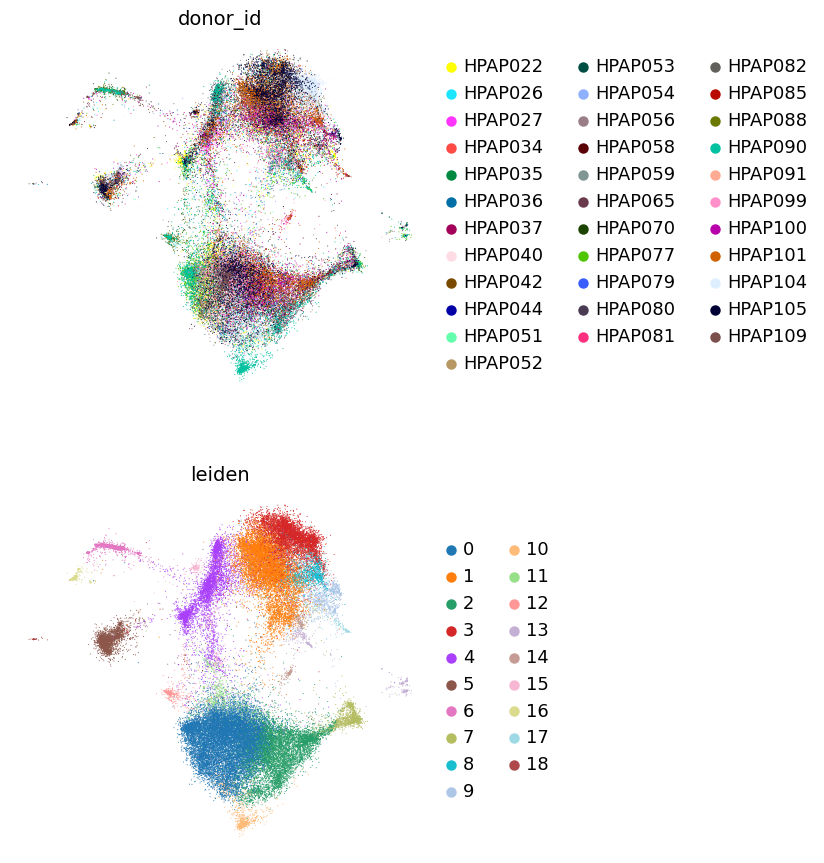

In [27]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=[batch_key, "leiden"],
    frameon=False,
    ncols=1,
)

### scANVI

In [28]:
# Normally we would need to run scVI first but we have already done that here
# model_scvi = scvi.model.SCVI(adata_scvi) etc.
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key=label_key, unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_type',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'donor_id',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  34   │
│         n_cells          │ 55776 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   5   │
│          n_vars          │ 1015  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │  HPAP022   │          0          │
│                       │  HPAP026   │          1          │
│                       │  HPAP027   │          2          │
│                       │  HPAP034   │          3          │
│                       │  HPAP035   │          4          │
│                       │  HPAP036   │          5          │
│                       │  HPAP037   │          6          │
│                       │  HPAP040   │          7          │
│                       │  HPAP042   │          8          │
│                       │  HPAP044   │          9          │
│                       │  HPAP051   │         10          │
│                       │  HPAP052   │         11          │
│                       │  HPAP053   │         12          │
│                       │  HPAP054   │         13          │
│                       │  HPAP056   │         14          │
│                       │  HPAP058   │         15          │
│                       │  HPAP059   │         16          │
│                       │  HPAP065   │         17          │
│                       │  HPAP070   │         18          │
│                       │  HPAP077   │         19          │
│                       │  HPAP079   │         20          │
│                       │  HPAP080   │         21          │
│                       │  HPAP081   │         22          │
│                       │  HPAP082   │         23          │
│                       │  HPAP085   │         24          │
│                       │  HPAP088   │         25          │
│                       │  HPAP090   │         26          │
│                       │  HPAP091   │         27          │
│                       │  HPAP099   │         28          │
│                       │  HPAP100   │         29          │
│                       │  HPAP101   │         30          │
│                       │  HPAP104   │         31          │
│                       │  HPAP105   │         32          │
│                       │  HPAP109   │         33          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │  alpha cell  │          0          │
│                        │  delta cell  │          1          │
│                        │ epsilon cell │          2          │
│                        │  beta cell   │          3          │
│                        │  unlabelled  │          4          │
└────────────────────────┴──────────────┴─────────────────────┘

In [29]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                                                   


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 10/10: 100%|█| 10/10 [02:30<00:00, 15.04s/it, v_num=1, train_loss_step=526

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█| 10/10 [02:30<00:00, 15.03s/it, v_num=1, train_loss_step=526


/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

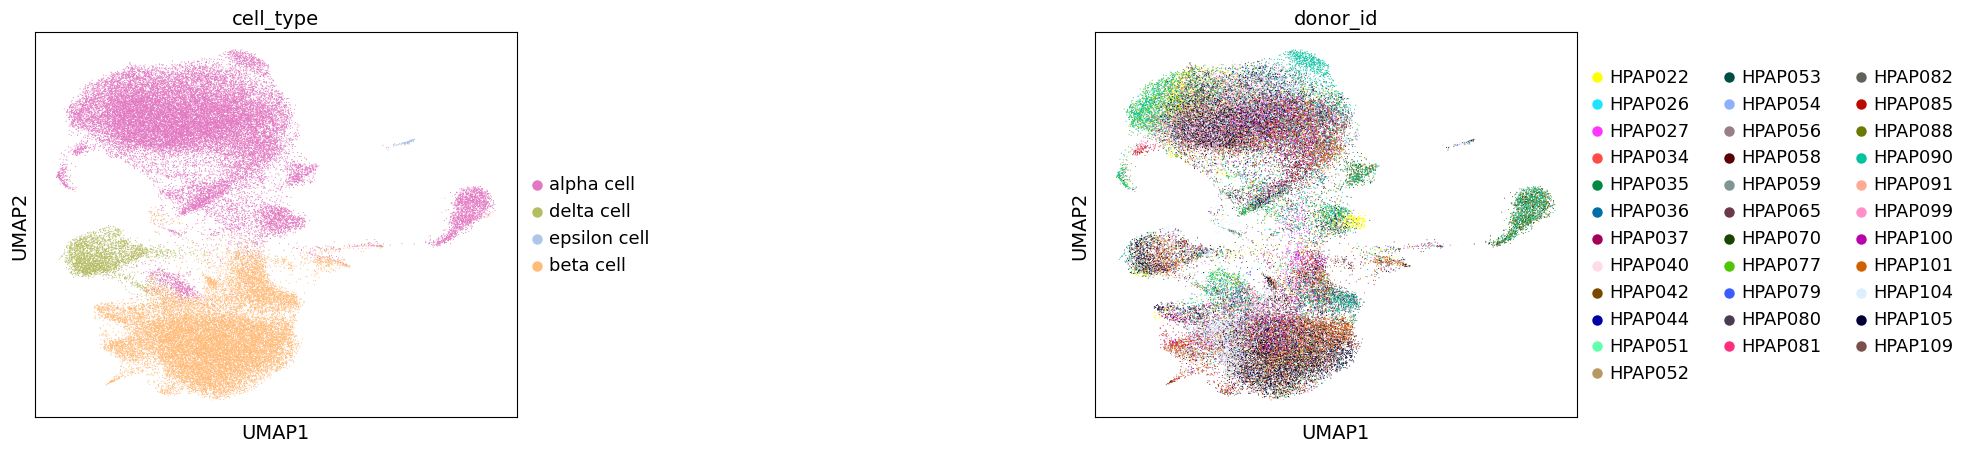

In [30]:
adata_scanvi = adata.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)

In [31]:
adata_scanvi.write("processed/adata_scanvi_interagted.h5ad")

## Key Takeaways

1. Visualize your data before attempting to correct for batch effects to assess the extent of the issue. Batch effect correction is not always required and it might mask the biological variation of interest.
2. If cell labels are available and biological variation is the most important, the usage of methods that can use these labels (such as scANVI) is advised.
3. Consider running several integration methods on your dataset and evaluating them with the **scIB** metrics to use the integration that is most robust for your use case.

## Quiz

1. What are the sources of batch effects?
2. What is the difference between technical and biological variation?
3. How does one evaluate whether the integration worked well or not? What are useful metrics for this purpose?

## Session information

### Python

In [22]:
import session_info

session_info.show()

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


### R

In [ ]:
%%R
sessioninfo::session_info()

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: int
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Luke Zappia
* Malte Lücken

### Reviewers

* Lukas Heumos